In [19]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
img = cv2.imread('./test_images/Sharapova.jpg')
img.shape

(1000, 1600, 3)

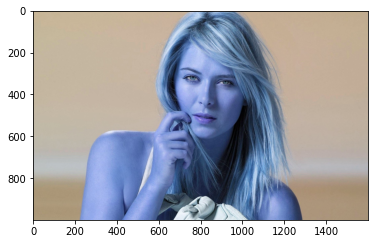

In [21]:
plt.imshow(img)

In [22]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1000, 1600)

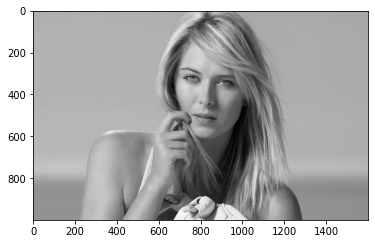

In [23]:
plt.imshow(gray, cmap='gray')

In [24]:
face_cascade = cv2.CascadeClassifier('./opencv/data/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/data/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[628, 178, 414, 414]])

In [25]:
(x,y,w,h) = faces[0]
x,y,w,h

(628, 178, 414, 414)

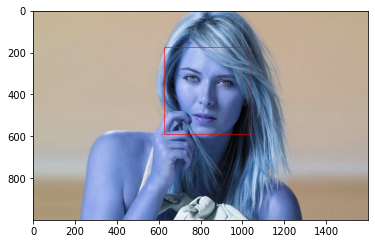

In [26]:
face_img = cv2.rectangle(img,(x,y), (x+w, y+h), (255,0,0),2 )
plt.imshow(face_img)

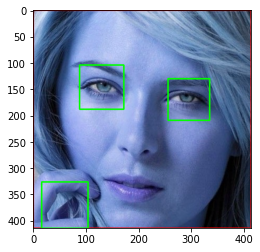

In [27]:
cv2.destroyAllWindows()

for(x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y),(x+w,y+h), (255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew,ey+eh), (0,255,0), 2)

        
plt.figure()
plt.imshow(roi_color, cmap='gray')
plt.show()

In [28]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

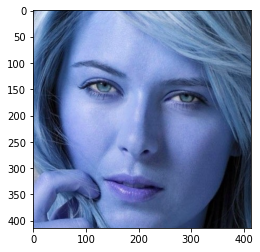

In [29]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/Sharapova.jpg')
plt.imshow(cropped_image)

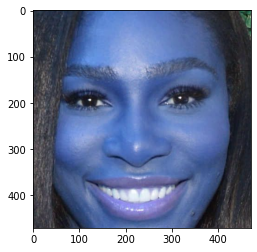

In [30]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/Serena.jpg')
plt.imshow(cropped_image)

In [31]:
path_to_data = "./images_dataset"
path_to_cr_data = "./images_dataset/cropped/"

In [32]:
import os 
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [33]:
img_dirs

['./images_dataset\\.ipynb_checkpoints',
 './images_dataset\\cropped',
 './images_dataset\\lionel_messi',
 './images_dataset\\maria_sharapova',
 './images_dataset\\roger_federer',
 './images_dataset\\serena_williams',
 './images_dataset\\virat_kohli']

In [34]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [36]:
cropped_image_dirs = []
celebrity_file_names_dict = {}


for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('\\')[-1]
    celebrity_file_names_dict[celebrity_name] = []   
    
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None: 
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + '.png'
            cropped_file_path = cropped_folder + '/' + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

In [ ]:
import numpy as np
import pywt
import cv2

def w2d(img, mode='haar', level=1):
    imgArray = img
    #datatype conversions
    #convert to greyscale
    imgArray = cv2.cvtColor(imgArray, cv2.COLOR_RGB2GRAY)
    #convert to float
    imgArray = np.float32(imgArray)
    imgArray/=255
    #compute coefficients
    coeffs = pywt.wavedec2(imgArray, mode, level=level)
    
    #process coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;
    
    #reconstruction
    imgArray_H = pywt.waverec2(coeffs_H, mode);
    imgArray_H *=255;
    imgArray_H = np.uint8(imgArray_H)
    
    return imgArray_H

In [ ]:
celebrity_file_names_dict

In [ ]:
class_dict = {}
count=0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

In [ ]:
x=[]
y=[]

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img=cv2.imread(training_image)
        if img is None:
            continue
        scaled_raw_img=cv2.resize(img, (32,32))
        img_har=w2d(img,'db1',5)
        scaled_img_har=cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        x.append(combined_img)
        y.append(class_dict[celebrity_name])

In [ ]:
x = np.array(x).reshape(len(x),4096).astype(float)